# Is "Best New Music" sampled independently?

In in my [previous notebook](https://github.com/nolanbconaway/pitchfork-data/blob/master/notebooks/review-score-exploration.ipynb), I observed that about 5% of reviews are given "Best New Music" status. In reality that value is a little low because i was analyzing data from before best new music came about. 

My question is about whether best new music reviews occur independently of one another. My hunch is that Pitchfork would try to spread these reviews out over time in order to better highlight each one.

I can think of couple ways to test this.

1. There are usually 4 reviews posted every day, Monday-Saturday. So, taking that 5% estimate at face value, if best new music reviews are distributed independently, then the probability of $k$ best new music reviews per day should be binomially distributed: $p(k) \sim Binomial(p=0.05, N=4)$.
2. Usually there is only one best new music on a given day, and not every day has a best new music. If best new music reviews are distributed independently, then the presence of best new music on day $n-1$ should not affect the probability of best new music on day $n$ (or $n+1$, and so on).

In [1]:
import sqlite3, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import binom
from scipy.signal import savgol_filter

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

con = sqlite3.connect('../pitchfork.db')
all_reviews = pd.read_sql('SELECT * FROM reviews WHERE pub_year < 2017', con)
years = pd.read_sql('SELECT * FROM years', con)
con.close()

## Cleaning...

The "Best New Music" label wasn't around until 2003, so I first need to get rid of data from before then. I'm also going to get rid of Sunday reviews, which are commonly high scoring but not always labeled as best new music. Finally, I'll eliminate any review that is associated with multiple years (these are most likely reissues). 

In [2]:
# convert pub_date to datetime object, get unix timestamps
reviews = all_reviews.copy(deep = True) # slice to new object
reviews['pub_date'] = pd.to_datetime(reviews.pub_date, format = '%Y-%m-%d')
reviews['unix_time'] = reviews.pub_date.astype(np.int64, copy = True) // 10**9

# find the first best new music, get rid of everything before it
first_bnm = reviews.loc[reviews.best_new_music == True, 'unix_time'].min()
reviews = reviews.loc[reviews.unix_time >= first_bnm]

# print out date of first bnm
idx = (reviews.unix_time == first_bnm) & (reviews.best_new_music == True)
first_bnm_str = datetime.datetime.fromtimestamp(first_bnm)
print('First best new music: ' + first_bnm_str.strftime('%B %d, %Y'))

# remove sunday reviews
reviews = reviews.loc[reviews.pub_weekday < 6]

# remove multi-year reviews
year_counts = years.groupby('reviewid').count().reset_index()
keepers = year_counts.loc[year_counts.year == 1, 'reviewid']
reviews = reviews.loc[reviews.reviewid.isin(keepers)]

# find overall proportion of best new music
proportion_bnm = np.mean(reviews.best_new_music)
print('Global p(bnm): ' + str(proportion_bnm))

First best new music: January 14, 2003
Global p(bnm): 0.0511534603811


So about 5.1% of releases are best new music since 2003. But that percentage assumes a steady rate over time. Below i explore how best new music has changed over the years.

## Best New Music from 2003-Present

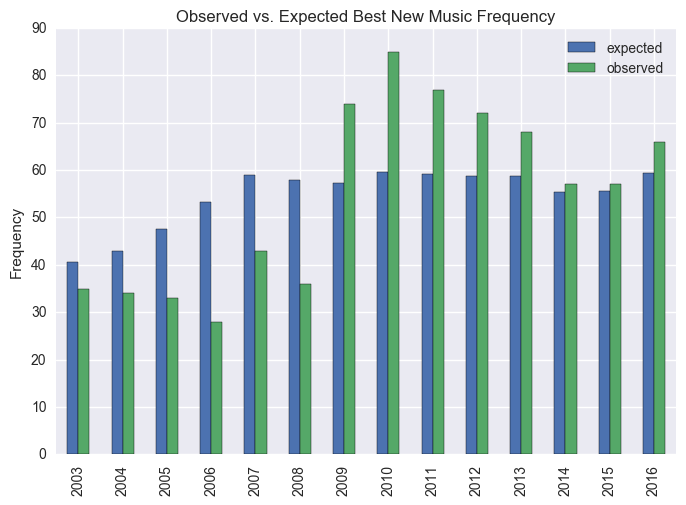

In [3]:
# compute oberved and expected number of best new music
table = reviews.groupby('pub_year')['best_new_music'].agg(['sum', 'count'])
table['expected'] = table['count'] * proportion_bnm
table.rename(columns = {'sum': 'observed'}, inplace=True)
table.plot(y = ['expected', 'observed'], kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('')
plt.title('Observed vs. Expected Best New Music Frequency')
plt.show()

### The observed and expected frequencies are almost never in sync.

Between 2003 and 2007 the expected frequency steadily increases, indicating that more and more reviews were being written. The distribution flattens out in 2007 and is stable as of 2016. 

Interestingly, the rate of best new music releases essentially doubles in 2008. There's a decline starting in 2011, but in 2016 the observed frequencies are still above their values prior to 2009.

Maybe an executive decision was made to have more best new music? Here's a plot showing the probability of best new music, as a function of score and year:

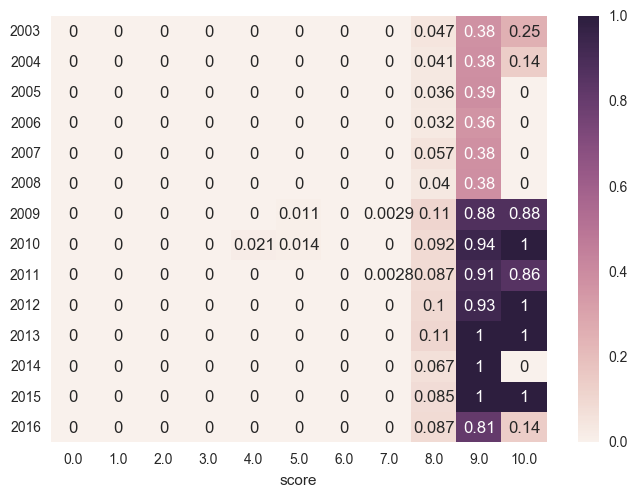

In [4]:
p_bmn = reviews.copy(deep = True)
p_bmn['score'] = np.round(p_bmn['score'])
p_bmn = pd.pivot_table(p_bmn, 
                columns = 'score', 
                index = 'pub_year', 
                values = 'best_new_music',
                aggfunc = 'mean',
                fill_value = 0.0)

ax = sns.heatmap(p_bmn, vmin = 0, vmax = 1, annot = True)
plt.ylabel('')
plt.show()

Prior to 2009, less than 40% of releases in the 8.5 - 9.5 range (rounded to 9.0 above) were best new music, but afterwards nearly all are.

## Is Best New Music binomially distributed?

If Pitchfork is independently sampling best new music reviews, then the frequency of best new music on a given day should follow from the binomial distribution, given the probability of best new music that year, and the number of reviews that day:

$$
p(k_{day}) \sim Binomial(p_{year}, N_{day})
$$

In [5]:
# get counts / observed bnm for each day
g = reviews.groupby('pub_date')
day_counts = g['best_new_music'].agg(['count','sum']).reset_index()
rename_cols = {'count':'N', 'sum':'observed'}
day_counts.rename(columns = rename_cols, inplace = True)
day_counts['pub_year'] = day_counts.pub_date.dt.year

# get probabilities for each year
year_ps = reviews.groupby('pub_year').best_new_music.mean().reset_index()
year_ps.rename(columns = {'best_new_music':'p'}, inplace = True)

# merge into table
data = pd.merge(day_counts, year_ps, on = 'pub_year')

# empty out columns for expected k probabilities
for k in range(5):
    data[k] = pd.Series(0, index = table.index)

# fill in data
for i, row in data.iterrows():
    if row.N < 5: xs = range(row.N + 1)
    else: xs = range(5)
    data.loc[i,xs] = binom.pmf(xs, row.N, row.p)
data.head(n=10)

,pub_date,N,observed,pub_year,p,0,1,2,3,4
0,2003-01-15,4,1,2003,0.04,0.83,0.15,0.01,3.30e-04,3.81e-06
1,2003-01-16,4,0,2003,0.04,0.83,0.15,0.01,3.30e-04,3.81e-06
2,2003-01-20,5,2,2003,0.04,0.80,0.18,0.02,7.88e-04,1.82e-05
3,2003-01-21,5,0,2003,0.04,0.80,0.18,0.02,7.88e-04,1.82e-05
4,2003-01-22,5,0,2003,0.04,0.80,0.18,0.02,7.88e-04,1.82e-05
5,2003-01-23,4,0,2003,0.04,0.83,0.15,0.01,3.30e-04,3.81e-06
6,2003-01-27,5,0,2003,0.04,0.80,0.18,0.02,7.88e-04,1.82e-05
7,2003-01-28,4,0,2003,0.04,0.83,0.15,0.01,3.30e-04,3.81e-06
8,2003-01-29,5,0,2003,0.04,0.80,0.18,0.02,7.88e-04,1.82e-05
9,2003-01-30,5,0,2003,0.04,0.80,0.18,0.02,7.88e-04,1.82e-05


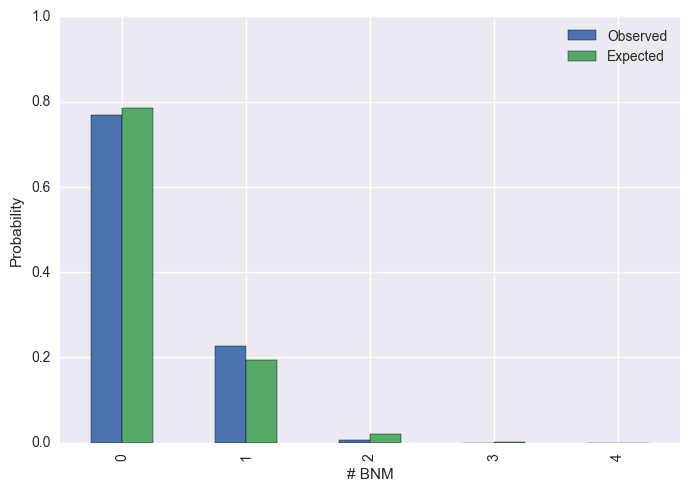

In [6]:
ks = np.arange(5)

# get observed and expected probs
observed_ps = np.array([sum(data.observed == k) for k in ks])
observed_ps = observed_ps / float(sum(observed_ps))
expected_ps = data[ks].mean().as_matrix()

df = pd.DataFrame(
                index = ks,
                data = dict(Expected = expected_ps,
                            Observed = observed_ps)
            )
df.plot(y = ['Observed','Expected'], kind = 'bar')
plt.ylim([0,1])
plt.ylabel('Probability')
plt.xlabel('# BNM')
plt.show()

### Result

The number of best new music reviews per day is pretty much what you'd expect if you had independently sampled from the probability distribution of each year. We could probably get en even tighter fit by setting the probabilities per month (or week, etc), but this is enough to satisfy me.

So Pitchfork probably isn't *trying* to prevent multiple best new music reviews from being published on a single day. It's simply very unlikely that this would happen, given the base rate of best new music reviews.

## Does Best New Music on day $n$ change the probability on day $n+1$?

If Pitchfork is trying to spread out best new music reviews, then publishing a best new music on day $n$ might lower the probability of best new music on day $n+1$, compared to if it had not published best new music on day $n$.

In [7]:
# create table where best new music looks ahead to see if there are future bnms
bnm_lookahead = reviews.groupby('unix_time')['best_new_music'].agg('any').to_frame()

lookahead  = 30     # number of days to look ahead
day_length = 86400  # seconds per day

# add lookahead columns
for i in range(lookahead):
   bnm_lookahead[i+1] = pd.Series(index = bnm_lookahead.index) 

# get all pub_dates
all_dates = bnm_lookahead.index.values

# fill out table
for i in all_dates:
    for j in range(1, lookahead+1):
        date = i + j*day_length
        if date not in all_dates: continue
        bnm_lookahead.loc[i, j] = bnm_lookahead.loc[date,'best_new_music']

bnm_lookahead.rename(columns = {'best_new_music':0}, inplace = True)
bnm_lookahead.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
unix_time,,,,,,,,,,,,,,,,,,,,,
1042588800,True,False,NaN,NaN,NaN,True,False,False,False,NaN,...,False,False,True,NaN,NaN,False,True,False,False,NaN
1042675200,False,NaN,NaN,NaN,True,False,False,False,NaN,NaN,...,False,True,NaN,NaN,False,True,False,False,NaN,NaN
1043020800,True,False,False,False,NaN,NaN,NaN,False,False,False,...,False,True,False,False,NaN,NaN,NaN,False,False,False
1043107200,False,False,False,NaN,NaN,NaN,False,False,False,False,...,True,False,False,NaN,NaN,NaN,False,False,False,False
1043193600,False,False,NaN,NaN,NaN,False,False,False,False,NaN,...,False,False,NaN,NaN,NaN,False,False,False,False,False


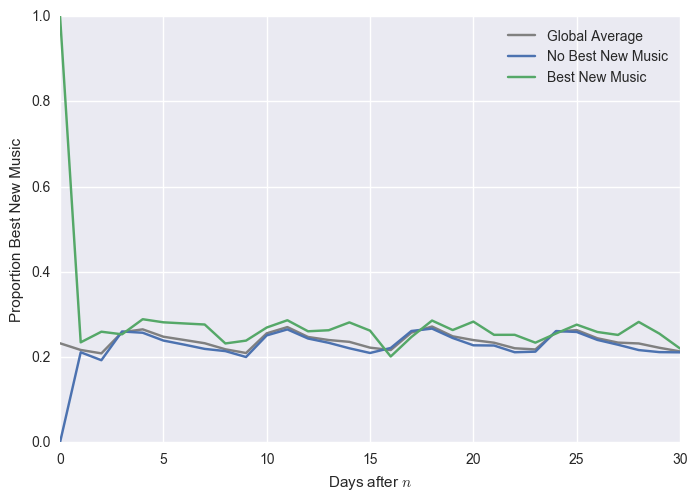

In [8]:
# plot the table

x = range(lookahead + 1)
y = bnm_lookahead.loc[:,x].mean().as_matrix()
plt.plot(x, y, color='gray', label = 'Global Average')


labels = ['No Best New Music', 'Best New Music']
for tf, rows in bnm_lookahead.groupby(0):

    y = rows.loc[:,x].mean()
    plt.plot(x, y, label = labels[tf])
    

plt.xlabel('Days after $n$')
plt.ylabel('Proportion Best New Music')

plt.legend()
plt.show()


The obvious pattern, that $n+1$ should be less likely if there was best new music on day $n$, does not show up. If anything, there is slightly *more* best new music in the 30 days following a best new music, not less.

But that overall difference is perplexing. If anything, the two distributions should be the same. Best new music shouldn't predict *more* best new music, right?

Maybe that's just because the probability of best new music varies systematically over time, and so *in general* the presence of best new music predicts itself. If that were true, then things should level out if only the data following the 2008 increase is considered.

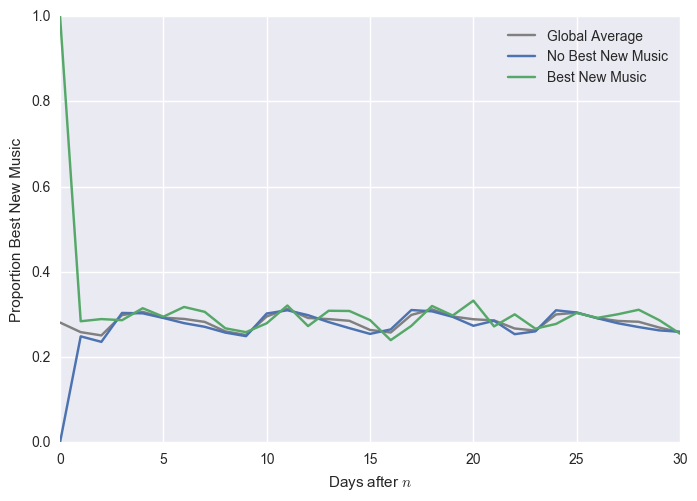

In [9]:
subset = bnm_lookahead.copy(deep = True)
subset = subset[subset.index.values > 1230768000] # after Jan 1 2009


x = range(lookahead + 1)
y = subset.loc[:,x].mean().as_matrix()
plt.plot(x, y, color='gray', label = 'Global Average')


labels = ['No Best New Music', 'Best New Music']
for tf, rows in subset.groupby(0):

    y = rows.loc[:,x].mean()
    plt.plot(x, y, label = labels[tf])
    

plt.xlabel('Days after $n$')
plt.ylabel('Proportion Best New Music')

plt.legend()
plt.show()


That did the trick. Now, the best new music and no best new music time-lines overlap pretty cleanly.

## Summary

I haven't found any evidence indicating that Pitchfork is purposefully spreading best new music reviews out over time. The number of best new music reviews per day lines up nicely with an independent binomial sampling model, and best new music reviews are equally likely every day, regardless of whether there was a best new music the day before (or two days before, and so on).